# Summary of Modeling for SPDR ETFs

In this notebook, I will summarize my findings from iterating through a host of models for the 11 sector ETFs for time frames of 1, 3, 6, and 12 months. The best scoring models performed incredibly well, and did not exhibit any characteristics of overfitting. That being said, on certain instances where the model predicted a given ETF would appreciate over its target time period and that ETF lost money, the losses had the potential to be quite large. I will begin by summarizing each sector's performance separately. 

![One Tree of an ExtraTreesClassifier Ensemble](./Files/Energy_Grid_12m_tree.jpg)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier

import datetime as dt

# New import of my custom class
from classification_classes import Model
from spider_classes import Materials, Energy, Financials, Industrials, Technology, Staples, Utilities, Health, \
Consumer, Real_Estate, Communication_Services
from other_functions import compare_curves

pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', 35)
sns.set_style("dark")

import warnings

# Suppress FutureWarnings for all of scikit-learn's modules
warnings.filterwarnings("ignore")

import pickle

In [114]:
# Feature Importances for the best models of each sector/timeframe
feature_importances = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Feature_Importances.csv')
feature_importances.rename(columns={"Unnamed: 0": "Model Target"}, inplace=True)
feature_importances.set_index("Model Target", inplace=True)

# Complete table of results
models_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/ALL_MODEL_DATA.csv', index_col=0)

# Original Data 
df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/FULL_DATA_W_PERC_CHANGES.csv')
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

In [3]:
# Load Pickled Classes -> if you want access, please reach out to me directly

with open('/Users/samalainabayeva/Desktop/Capstone Project/SPDR_classes.pkl', 'rb') as file:
    model_collection = pickle.load(file)

In [4]:
# Providing access to Class Objects

Materials = model_collection[0]
Energy = model_collection[1]
Financials = model_collection[2]
Industrials = model_collection[3]
Technology = model_collection[4]
Staples = model_collection[5]
Utilities = model_collection[6]
Health = model_collection[7]
Consumer_Disc = model_collection[8]
Real_Estate = model_collection[9]
Comms = model_collection[10]

In [218]:
# Metrics of the models from the previous notebook

Materials_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Materials.csv', index_col=0)
Energy_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Energy.csv', index_col=0)
Financials_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Financials.csv', index_col=0)
Industrials_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Industrials.csv', index_col=0)
Technology_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Technology.csv', index_col=0)
Staples_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Staples.csv', index_col=0)
Utilities_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Utilities.csv', index_col=0)
Health_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Health_Care.csv', index_col=0)
Consumer_Disc_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Consumer_Disc.csv', index_col=0)
Real_Estate_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Real_Estate.csv', index_col=0)
Comms_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Communication_Services.csv', index_col=0)
Materials_df.loc[28, 'name'] = "Gridsearched ETC Materials 12-Month"
Materials[32].name = "Gridsearched ETC Materials 12-Month"

In [219]:
df.head(2)

,Ticker,Adj Close,Close,High,Low,Open,Volume,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),...,HML,RMW,CMA,one_months_later,three_months_later,six_months_later,twelve_months_later,One_Month_Positive,Three_Month_Positive,Six_Month_Positive,Twelve_Month_Positive,Quarter,cycle_year,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-01-29,XLB,12.173974,21.109375,21.109375,20.953125,20.953125,400.0,-0.113866,45.359138,11.895115,12.260721,12.626327,12.991933,13.357539,0.428209,-0.181912,0.0049,...,-0.0062,0.0044,-0.0057,1999-03-01,1999-04-29,1999-07-29,2000-01-31,1.0,1.0,1.0,1.0,1,3,0.003701,0.304892,0.224778,0.120443
1999-01-29,XLE,11.670676,21.812500,21.812500,21.437500,21.687500,18600.0,-0.148177,31.112282,11.538889,11.886099,12.233308,12.580518,12.927728,0.420353,-0.327213,0.2171,...,-0.0062,0.0044,-0.0057,1999-03-01,1999-04-29,1999-07-29,2000-01-31,0.0,1.0,1.0,1.0,1,3,-0.018625,0.321352,0.294085,0.272486


In [231]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_test_accuracy(df, sector_name:str, num_include=-1):
    fig, ax = plt.subplots(figsize=(10,7))
    palette = sns.color_palette("flare", n_colors=10)
    data = df[['name', 'test_accuracy']].sort_values(by="test_accuracy", ascending=False)[0:num_include]
    sns.barplot(data=data, y='name', x="test_accuracy", palette=palette)
    ax.set_xlabel("Test Accuracy")
    ax.set_ylabel("Model Name")
    ax.set_title(f"Performance of Models - {sector_name}")
    ax.set_xticks(np.arange(0,1,.1))
    ax.set_xticklabels(np.arange(0,100,10))
    plt.grid(False);
    
    
    
def print_feature_importances(start, stop, interval=1, feats=5, data=feature_importances):
    for i in range(start, stop, interval):
        print("*" *40)
        print(f"Top {feats} Feature Importance(s):")
        print(feature_importances.iloc[i].sort_values(ascending=False)[:feats])
        
        

def describe_predictions(model, ticker, df=df, cat=1):
    targets = df[df["Ticker"] == ticker][['One_Month_Change', 'Three_Month_Change', 'Six_Month_Change', \
                                         'Twelve_Month_Change']]

    combined_df = model.X_test.join(targets)
    predictions = list(model.y_pred)
    combined_df["Y_PREDS"] = predictions

    return combined_df[combined_df["Y_PREDS"] == cat][['One_Month_Change', 'Three_Month_Change', 'Six_Month_Change',\
                                                     'Twelve_Month_Change']].describe()


def show_time_horizon(df, time_horizon):
    time_dict = {"One":"1-Month", "Three":"3-Month", "Six":'6-Month', "Twelve":'12-Month'}
    return df[df['name'].str.contains(str(time_dict[time_horizon]))].sort_values(by="test_accuracy", ascending=False)

<hr style="border: 4px solid black">

# Materials

The data for the Materials sector shows that on a shorter time horizon, momentum has the greatest relative importance, as evidenced by the technical indicators having the greatest influence on increasing purity. The longer the time horizon, the more macro factors like interest rates and GDP were able to create meaningful splits in our tree based models. Considering the best model was predicting 12-Month appreciation, the "describe" table and confusion matrix are very instuctive in evaluating performance. Of note, even this extremely accurate predictive model still had 10 false positives, and the worst false positive resulted in a 5.7% loss. The best prediction resulted in a 92.5% gain. 

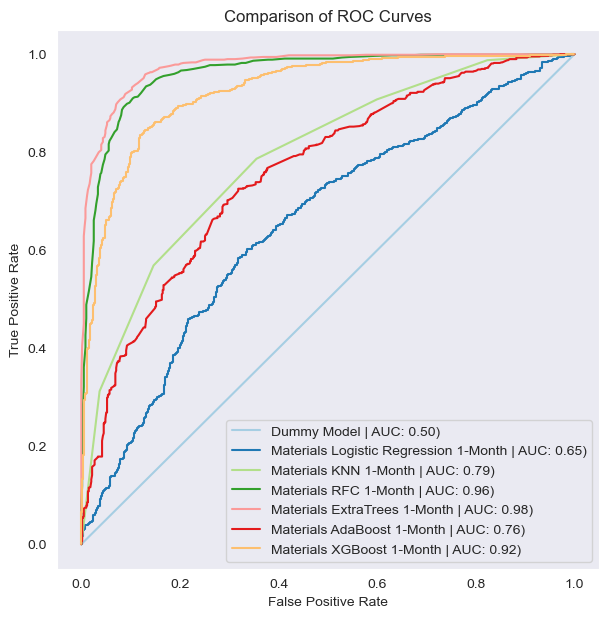

In [227]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Materials[0], Materials[1],Materials[2],Materials[3],Materials[4],Materials[5], Materials[6]])

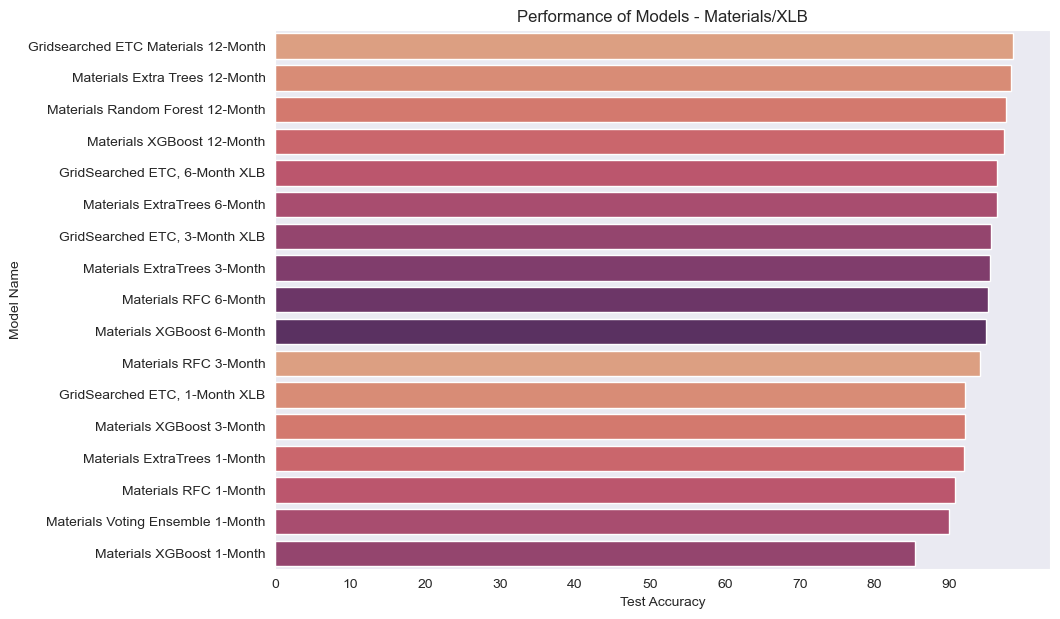

In [234]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Materials_df, "Materials/XLB", num_include=17)

In [225]:
# These were the models with the highest accuracy score for this ETF

show_time_horizon(Materials_df, "Twelve")[:]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
28,Gridsearched ETC Materials 12-Month,0.979024,0.986948,0.983155,0.985039,0.060795,0.985274,0.990602,0.988743,0.989671,0.092646,0.996232
27,Materials Extra Trees 12-Month,0.979024,0.987252,0.982836,0.985032,0.069167,0.981928,0.987793,0.986867,0.987330,0.095225,0.996001
26,Materials Random Forest 12-Month,0.971659,0.979679,0.979976,0.979821,0.087653,0.975904,0.984934,0.981238,0.983083,0.117441,0.994878
25,Materials XGBoost 12-Month,0.969429,0.978383,0.978071,0.978221,0.092013,0.973226,0.981238,0.981238,0.981238,0.083920,0.994275
24,Materials Logistic Regression 12-Month,0.826599,0.848401,0.917034,0.881306,0.389448,0.846051,0.873882,0.916510,0.894689,0.373387,0.884021
23,Dummy Materials 12-Month,0.702075,0.702075,1.000000,0.824964,10.738292,0.713521,0.713521,1.000000,0.832812,10.325759,0.500000


### How did our model perform when predicting "BUY"?
Our best model was a 12-month model, based on the ExtraTreesClassifier. As you can see below, the median return on predicted "buys" was 16%. 

In [237]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Materials[32], "XLB", cat=1)

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,1064.000000,1064.000000,1064.000000,1064.000000
mean,0.015206,0.047595,0.095232,0.184612
std,0.063396,0.092033,0.117998,0.131313
min,-0.328934,-0.367629,-0.249243,-0.057450
25%,-0.017188,-0.002969,0.021982,0.099510
50%,0.018326,0.050263,0.090358,0.159914
75%,0.048695,0.099596,0.161215,0.240284
max,0.319829,0.513839,0.650620,0.925471


### Improvements
The confusion matrices below show how substantially our best model improved over the dummy model. The picture at the top of the notebook displays how intricate decision trees can get, but what was very impressive to me was that none of the models ever overfit in a meaningful way.

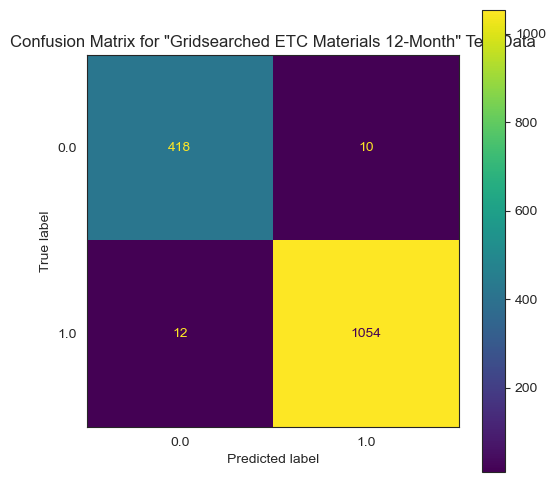

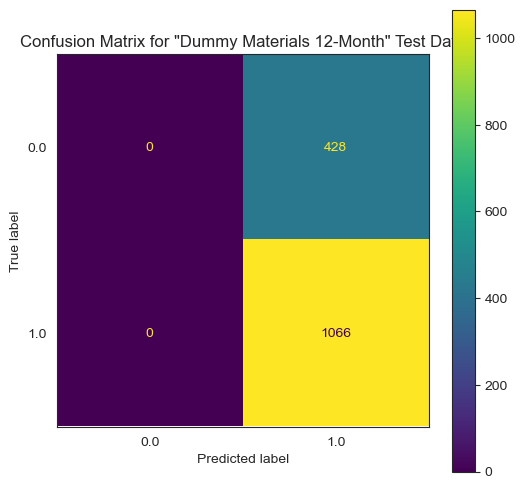

In [235]:
# Shows the best model's predictions and the dummy for that particular time horizon

Materials[32].confusion_matrix(), Materials[23].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [238]:
# Feature Importances for each time-horizon's best model
print_feature_importances(0, 4, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
20_day_SMA               0.054590
MACD                     0.053367
lower_bollinger_band     0.053166
lowest_bollinger_band    0.052988
ATR                      0.052783
Name: 1 Month XLB, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest Rates           0.061072
lowest_bollinger_band    0.051249
one_up_bollinger_band    0.049634
lower_bollinger_band     0.049101
20_day_SMA               0.047810
Name: 3-Month XLB, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest Rates           0.069081
GDP                      0.063467
20_day_SMA               0.049903
upper_bollinger_band     0.049809
one_up_bollinger_band    0.048229
Name: 6-Month XLB, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP                      0.075225
cycle_year_1             0.072214
Interest Rates           0.069435
upper_